<a href="https://colab.research.google.com/github/liuxx479/NGphotoz/blob/master/prep_mass_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
sys.modules["mpi4py"] = None
from lenstools import ConvergenceMap
from IPython.display import Image
%matplotlib inline

### goals of this notebook
##### 1) compute the nubmer density per z bin, using the fiducial photo-z (sigma_z=0, or step function was used)
##### 2) add noise as GRF to each redshift
##### 3) smooth the maps
##### 4) define the bin edges
##### 5) compute peaks, minima, PDF, MFs, moments
##### 6) turn this into a python code

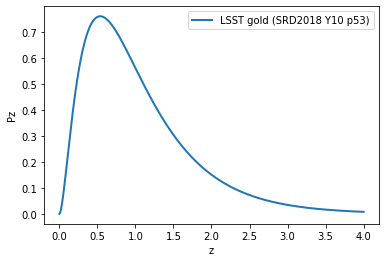

In [2]:
##### number density per redshift bins
def Pz_norm(zp_support, pz):
  return pz/np.trapz(pz, zp_support)

def Pz_norm_tomo(zp_support, pz):
  return array([Pz_norm(zp_support, ipz) for ipz in pz])

zarr=np.linspace(0,4, 501)
delta_z=0.5

tomo_centers=np.arange(0.5, 3, delta_z)
tomo_widths=np.ones(5)*delta_z
tomo_edges = np.array([tomo_centers-delta_z/2, tomo_centers+delta_z/2]).T

z0_SRD, alpha_SRD = 0.11, 0.68
Pz_SRD_unnorm = lambda z: z**2 * exp(-(z/z0_SRD)**alpha_SRD)
Pz_SRD_norm = lambda z: Pz_norm(z, Pz_SRD_unnorm(z))

plot(zarr, Pz_SRD_norm(zarr), lw=2, label='LSST gold (SRD2018 Y10 p53)')
xlabel('z')
ylabel('Pz')
legend()
show()

In [4]:
############ fiducial model: pz_true.txt 
### zbias=0, sigma_z=0, outlier=0; it should have sharp cut off at the bin edges ([0.25, 0.75], [0.75, 1.25]...)
####### LSST SRD Y10 numbers page 53
######## SRD: https://arxiv.org/abs/1809.01669
## neff: (z0, α) = (0.13, 0.78) for Y1 and (0.11, 0.68) for Y10
## neff = 10 and 27 arcmin−2 as the lensing neff in Y1 and Y10
## however, according to the original Chang 2013 paper, unmasked neff=37
sigma_e = 0.26 ## per component, do I need a sqrt(2) to get both components? (I didn't do this in 2014..)
neff = 37 ## chang+2013 n=46, for fiducial case
ngal = 46

### 1) compute the nubmer density per z bin

In [5]:
ngal_tomo = np.zeros(5)
Pz_norm_factor = np.trapz(Pz_SRD_unnorm(zarr),zarr)
print (Pz_norm_factor)

for i in range(5):
    iz0,iz1=tomo_edges[i]
    izarr=zarr[where((zarr>iz0)&(zarr<iz1))]
    ngal_tomo[i]= ngal * np.trapz(Pz_SRD_unnorm(izarr), izarr) / Pz_norm_factor

0.020049679068572506


In [10]:
print ('number of galaxies per redshift bin \n(ngal=%i, %s galaxies in 5 bins):'%(ngal, sum(ngal_tomo)))
for i in range(5):
    print ('z=%s, ngal=%.2f /arcmin^2'%(tomo_edges[i], ngal_tomo[i]))

number of galaxies per redshift bin 
(ngal=46, 40.99631314209885 galaxies in 5 bins):
z=[0.25 0.75], ngal=16.07 /arcmin^2
z=[0.75 1.25], ngal=12.82 /arcmin^2
z=[1.25 1.75], ngal=6.93 /arcmin^2
z=[1.75 2.25], ngal=3.51 /arcmin^2
z=[2.25 2.75], ngal=1.66 /arcmin^2


### 2) add noise as GRF to each redshift

In [11]:
###### get a set of 5 test maps
test_dir = '/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/06_f/'
os.listdir(test_dir)[:10]
fnames = [test_dir+'kappa_LSST-SRD_tomo%i_cone5.fits'%(i) for i in range(1,6)]
test_maps = array([fits.open(ifn)[0].data for ifn in fnames])
istds = [std(it) for it in test_maps]
print (istds)

[0.007314169, 0.019146424, 0.031151935, 0.041499652, 0.050280314]


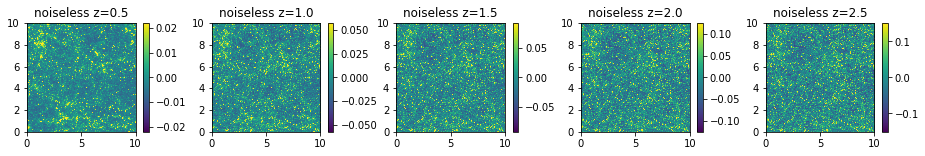

In [23]:
#### plot original kappa maps
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds[i]
    imshow(test_maps[i], vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('noiseless z=%.1f'%(tomo_centers[i]))
    colorbar()


In [14]:
### white noise maps for shape noise
map_side_deg = 10*u.degree
pixel_angular_side = map_side_deg / test_maps[0].shape[0]

sigma_pix_arr =[ (sigma_e / (pixel_angular_side * sqrt(ingal / u.arcmin**2))).decompose().value
                for ingal in ngal_tomo]

print (map_side_deg, test_maps[0].shape[0])
print (pixel_angular_side.to (u.arcmin))
print (sigma_pix_arr)

np.random.seed(2)
noise_maps = [np.random.normal(loc=0.0, scale=sigma_pix_arr[i], size=test_maps[0].shape) 
              for i in range(5)]

# #Generate shape noise
#sigma = ((0.15 + 0.035*z) / (pixel_angular_side * np.sqrt(ngal))).decompose().value
# np.random.seed(seed)
# noise_map = np.random.normal(loc=0.0,scale=sigma,size=self.shape) 

10.0 deg 7745
0.0774693350548741 arcmin
[0.8373384105463355, 0.9372762624156529, 1.274722171595974, 1.7907843269067931, 2.6010219215711436]


In [15]:
## turn it into convergencemap instance
conv_maps = [ConvergenceMap(data=test_maps[i]+noise_maps[i], angle=map_side_deg) for i in range(5)]

In [26]:
istds_noisy = [conv_maps[i].std() for i in range(5)]
print (istds_noisy)

[0.8372021544930138, 0.9374195324734388, 1.275025662475702, 1.7912769418845758, 2.6011430478816924]


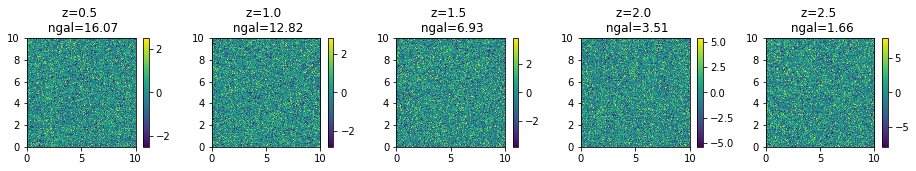

In [34]:
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds_noisy[i]
    imshow(conv_maps[i].data, vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('z=%.1f \n ngal=%.2f'%(tomo_centers[i], ngal_tomo[i]))
    colorbar()

### 3) smooth the maps

In [31]:
smoothed_conv_maps= [conv_maps[i].smooth(1*u.arcmin) for i in range(5)]

In [32]:
istds_smoothed = [smoothed_conv_maps[i].std() for i in range(5)]
print (istds_smoothed)

[0.01920201148348406, 0.02411806569314141, 0.033861341321017376, 0.04588400024663679, 0.06355282713836714]


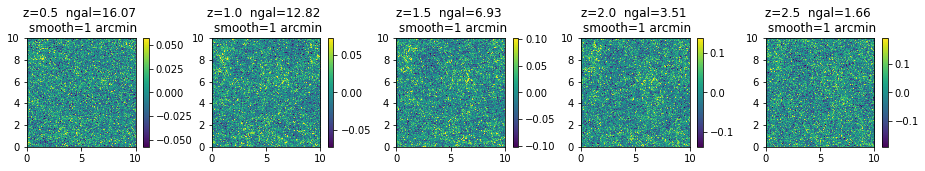

In [36]:
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds_smoothed[i]
    imshow(smoothed_conv_maps[i].data, vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('z=%.1f  ngal=%.2f \n smooth=1 arcmin'%(tomo_centers[i], ngal_tomo[i]))
    colorbar()

### 4) define the bin edges
<img src="theory_noise_smoothed.jpg" width="400">

In [69]:
######### the std of noise maps
istds_noise_smoothed = array([ConvergenceMap(data=noise_maps[i], angle=map_side_deg).smooth(1*u.arcmin,mode='wrap').std() 
                            for i in range(5)])

In [79]:
# this is from Coulton2019, not sure where is the log(2) factor from
# const_n = 1/sqrt(4*log(2)*pi)#0.3388303758015525 

# this matches yang2011, with their 1 arcmin = my/usual 1/sqrt(2) arcmin
const_n = 1/sqrt(4*pi)

## theta_g in unit of 1 arcmin, ngal in unit of 1/armin^2
sigma_smooth = lambda ngal, theta_g: const_n* sigma_e/(theta_g * sqrt(ngal))
sigma_n_theory = sigma_smooth (array(ngal_tomo), 1)

print ('std for smoothed noisy maps:')
print (sigma_n_theory, 'theory')
print (istds_GRF_smoothed, 'sim')
print (sigma_n_theory/istds_GRF_smoothed, 'theory/sim')

std for smoothed noisy maps:
[0.01829894 0.02048295 0.02785739 0.03913526 0.05684194] theory
[0.01834497 0.02051243 0.02805404 0.03922925 0.05713196] sim
[0.99749088 0.99856288 0.99299018 0.99760407 0.9949237 ] theory/sim


In [81]:
!git add prep_map_stats.ipynb; git commit -m 'update prep_map.stats; smooth the map'; git push

[master bee2b6d] update prep_map.stats; smooth the map
 1 file changed, 20 insertions(+), 29 deletions(-)
Counting objects: 3, done.
Delta compression using up to 64 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 487 bytes | 487.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To ssh://github.com/liuxx479/NGphotoz.git
   bd8e928..bee2b6d  master -> master


In [82]:
linspace(-5,5,21)

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])